In [ ]:
!pip install mne
import mne
import numpy as np
from matplotlib import pyplot as plt
from PIL import Image
from sklearn.model_selection import train_test_split
import tensorflow as tf
from keras import layers
from tensorflow.keras import utils as np_utils
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Activation, Permute, Dropout
from tensorflow.keras.layers import Conv2D, MaxPooling2D, AveragePooling2D
from tensorflow.keras.layers import SeparableConv2D, DepthwiseConv2D
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import SpatialDropout2D
from tensorflow.keras.regularizers import l1_l2
from tensorflow.keras.layers import Input, Flatten
from tensorflow.keras.constraints import max_norm
from tensorflow.keras import backend as K

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from google.colab import drive
drive.mount('/content/drive')
file='/content/drive/MyDrive/BCICIV_2a_gdf/A09T.gdf'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:

raw=mne.io.read_raw_gdf(file, preload=True, stim_channel='auto', verbose=False)
# Filter settings
low_cut = 4
hi_cut  = 40

raw_filt = raw.copy().filter(low_cut, hi_cut)
#raw.filter(4,40.,fir_design='firwin')
#raw.plot_psd(area_mode='range', tmax=10.0,average=False)
rawdata = raw_filt.get_data()
print(rawdata.shape)
events, event_id = mne.events_from_annotations(raw_filt)
print(events.shape[0])
LeftHand = []
RightHand = []
BothFeet = []
Tongue = []
for i in range(events.shape[0]-1):
  Data = rawdata[:,events[i,0]+125:events[i,0]+1125]
  if (events[i,2] == 7):
    LeftHand.append(Data)
  elif (events[i,2] == 8):
    RightHand.append(Data)
  elif (events[i,2] == 9):
     BothFeet.append(Data)
  elif (events[i,2] == 10):
     Tongue.append(Data)


LeftHand= np.delete(LeftHand, [22,23,24], 1)
RightHand = np.delete(RightHand, [22,23,24], 1)
BothFeet = np.delete(BothFeet, [22,23,24], 1)
Tongue= np.delete(Tongue, [22,23,24], 1)

print(LeftHand.shape)
print(RightHand.shape)
print(BothFeet.shape)
print(Tongue.shape)

def standardlizeSig(data):
  base = np.mean(data)
  std = np.std(data)
  standardlized_data = (data-base)/std
  del base, std
  return standardlized_data


leftLabels = [0] * LeftHand.shape[0]
rightLabels = [1] * RightHand.shape[0]
footLabels = [2] * BothFeet.shape[0]
tongueLabels = [3] * Tongue.shape[0]
EntireClassLabels = leftLabels + rightLabels + footLabels + tongueLabels
EntireClassLabels = np.array(EntireClassLabels)
EntireClassData = np.concatenate((LeftHand, RightHand, BothFeet, Tongue))

#Standardize EEG signal
for i in range (EntireClassData.shape[0]):
  EntireClassData[i]=standardlizeSig(EntireClassData[i,:,:])

X_train, X_rem, Y_train, Y_rem = train_test_split(EntireClassData, EntireClassLabels, test_size=0.4, random_state=42)
X_validate,X_test,Y_validate,Y_test  = train_test_split(X_rem, Y_rem, test_size=0.1,random_state=42)

print (X_train.shape,X_validate.shape,X_test.shape)


/usr/local/lib/python3.7/dist-packages/mne/io/edf/edf.py:1155: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  etmode = np.fromstring(etmode, UINT8).tolist()[0]
/usr/lib/python3.7/contextlib.py:119: RuntimeWarning: Channel names are not unique, found duplicates for: {'EEG'}. Applying running numbers for duplicates.
  next(self.gen)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 3.00 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 413 samples (1.652 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s


(25, 673328)
Used Annotations descriptions: ['1023', '1072', '276', '277', '32766', '768', '769', '770', '771', '772']


[Parallel(n_jobs=1)]: Done  25 out of  25 | elapsed:    0.6s finished


639
(72, 22, 1000)
(72, 22, 1000)
(71, 22, 1000)
(72, 22, 1000)
(172, 22, 1000) (103, 22, 1000) (12, 22, 1000)


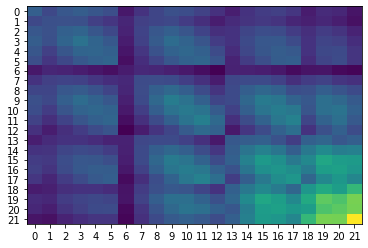

In [ ]:
cov=np.cov(X_train[1])
fig=plt.imshow(cov, aspect='auto')
plt.xticks(np.arange(0, 22, 1.0))
plt.yticks(np.arange(0, 22, 1.0))
plt.show()

In [ ]:
mu=0.0 # mean value
std =0.5 # standard deviation value
def gaussian_noise(x,mu,std):
    noise = np.random.normal(mu, std, size = x.shape)
    x_noisy = x + noise
    return x_noisy 

TrainData_temp=[]
TrainData_temp_label=[]
for i in range(X_train.shape[0]):
  NoisyData=gaussian_noise(X_train[i],mu,std)
  TrainData_temp.append(NoisyData)
  TrainData_temp_label.append(Y_train[i])


TrainData_temp=np.array(TrainData_temp)
TrainData_temp_label=np.array(TrainData_temp_label)
print(TrainData_temp.shape,TrainData_temp_label)


TrainData=np.concatenate((X_train,TrainData_temp))
TrainLabel=np.concatenate((Y_train,TrainData_temp_label))
print(TrainLabel.shape, TrainData.shape)



(172, 22, 1000) [1 0 1 1 1 1 2 1 2 1 2 2 2 3 1 1 0 3 3 1 2 3 3 3 2 0 2 1 2 0 0 0 1 3 3 0 1
 2 2 0 3 2 1 0 3 1 2 0 3 1 3 3 1 0 0 2 2 2 3 0 3 3 0 3 0 1 0 2 2 3 3 1 0 1
 1 3 3 0 3 0 0 2 2 0 1 3 2 0 3 3 1 0 3 3 2 0 0 1 3 3 2 2 0 3 2 2 3 3 0 1 0
 1 0 3 1 0 2 1 2 0 3 0 2 2 3 1 1 1 1 0 1 0 3 0 0 1 1 0 2 1 3 1 3 3 0 0 2 2
 2 2 0 0 3 3 0 2 2 3 2 1 2 1 1 2 1 3 0 2 0 1 3 1]
(344,) (344, 22, 1000)


In [ ]:
import cv2
#Cross covariance matrix
TrainData_cov=[]
for i in range(TrainData.shape[0]):
  cov=np.cov(TrainData[i])
  TrainData_cov.append(cov)
TrainData_cov=np.array(TrainData_cov)
print(TrainData_cov.shape)

#Adding new dimension and repeating the data (22x22) three times
TrainData_new_dim = np.repeat(TrainData_cov[..., np.newaxis], 3, -1)


#Creating an empty array with the dimension (number of trials,32,32,3)
TrainData_resize = np.ndarray(shape=(TrainData_new_dim.shape[0],32,32,3))

#Resize all the trial to shape (32,32,3) from (22,22,3)
for i in range(TrainData_new_dim.shape[0]):
    TrainData_resize[i] = cv2.resize(TrainData_new_dim[i], (32,32),interpolation = cv2.INTER_AREA)
print(TrainData_resize.shape)



(344, 22, 22)
(344, 32, 32, 3)


In [ ]:
IMG_HEIGHT=32
IMG_WIDTH=32
CHANNAL=3
ValidData_cov=[]
for i in range(X_validate.shape[0]):
  cov=np.cov(X_validate[i])
  ValidData_cov.append(cov)
ValidData_cov=np.array(ValidData_cov)
print(ValidData_cov.shape)
rgb_valid_batch = np.repeat(ValidData_cov[..., np.newaxis], 3, -1)
print(rgb_valid_batch.shape)
resized_valid = np.ndarray(shape=(rgb_valid_batch.shape[0],IMG_HEIGHT,IMG_WIDTH,CHANNAL))
for rec in range(rgb_valid_batch.shape[0]):
    resized_valid[rec] = cv2.resize(rgb_valid_batch[rec], (IMG_HEIGHT,IMG_WIDTH),interpolation = cv2.INTER_AREA)
print(resized_valid.shape)

(103, 22, 22)
(103, 22, 22, 3)
(103, 32, 32, 3)


In [ ]:
TestData_cov=[]
for i in range(X_test.shape[0]):
  cov=np.cov(X_test[i])
  TestData_cov.append(cov)
TestData_cov=np.array(TestData_cov)
print(TestData_cov.shape)
rgb_test_batch = np.repeat(TestData_cov[..., np.newaxis], 3, -1)
print(rgb_test_batch.shape)
resized_test = np.ndarray(shape=(rgb_test_batch.shape[0],IMG_HEIGHT,IMG_WIDTH,CHANNAL))
for rec in range(rgb_test_batch.shape[0]):
    resized_test[rec] = cv2.resize(rgb_test_batch[rec], (IMG_HEIGHT,IMG_WIDTH),interpolation = cv2.INTER_AREA)
print(resized_test.shape)

(12, 22, 22)
(12, 22, 22, 3)
(12, 32, 32, 3)


In [ ]:
TrainLabel1     = TrainLabel
ValidLabel1  = Y_validate
TestLabel1  = Y_test


In [ ]:
from tensorflow.keras.models import Sequential
resnet_model = Sequential()

pretrained_model= tf.keras.applications.ResNet50(include_top=False,
                   input_shape=(32,32,3),
                   pooling='avg',classes=4,
                   weights='imagenet')
for layer in pretrained_model.layers:
        layer.trainable=False
resnet_model.add(pretrained_model)


In [ ]:
resnet_model.add(Flatten())
#resnet_model.add(Dense(512, activation='relu'))
resnet_model.add(Dense(128, activation='relu'))
resnet_model.add(Dense(64, activation='relu'))
resnet_model.add(Dense(4, activation='softmax'))

In [ ]:

resnet_model.compile(optimizer='adam',loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])

fittedModel = resnet_model.fit(TrainData_resize, TrainLabel1, batch_size = 64, epochs = 250, 
                        validation_data=(resized_valid, ValidLabel1))
                       

Epoch 1/250


/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


6/6 [==============================] - 9s 629ms/step - loss: 1.6576 - accuracy: 0.2762 - val_loss: 1.4752 - val_accuracy: 0.2136
Epoch 2/250
6/6 [==============================] - 0s 35ms/step - loss: 1.4239 - accuracy: 0.2645 - val_loss: 1.4065 - val_accuracy: 0.2524
Epoch 3/250
6/6 [==============================] - 0s 40ms/step - loss: 1.4302 - accuracy: 0.2355 - val_loss: 1.4015 - val_accuracy: 0.2524
Epoch 4/250
6/6 [==============================] - 0s 31ms/step - loss: 1.4150 - accuracy: 0.2267 - val_loss: 1.3969 - val_accuracy: 0.3204
Epoch 5/250
6/6 [==============================] - 0s 41ms/step - loss: 1.3903 - accuracy: 0.2733 - val_loss: 1.3887 - val_accuracy: 0.2233
Epoch 6/250
6/6 [==============================] - 0s 41ms/step - loss: 1.3881 - accuracy: 0.2791 - val_loss: 1.3892 - val_accuracy: 0.2524
Epoch 7/250
6/6 [==============================] - 0s 39ms/step - loss: 1.4084 - accuracy: 0.2471 - val_loss: 1.3887 - val_accuracy: 0.2524
Epoch 8/250
6/6 [==============

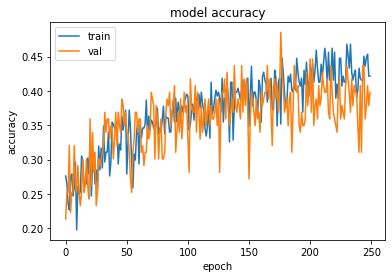

In [ ]:
plt.plot(fittedModel.history['accuracy'])
plt.plot(fittedModel.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

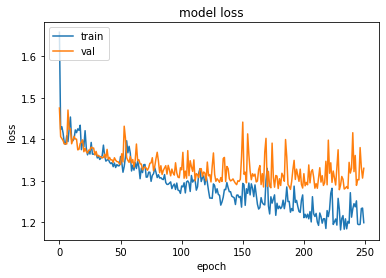

In [ ]:
plt.plot(fittedModel.history['loss'])
plt.plot(fittedModel.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
print(np.mean(fittedModel.history['val_accuracy']))

0.35856310719251633


In [ ]:
resnet_model.evaluate(resized_test, TestLabel1)
print(resized_test.shape,TestLabel1.shape)

1/1 [==============================] - 0s 424ms/step - loss: 1.7032 - accuracy: 0.3333
(12, 32, 32, 3) (12,)


In [ ]:
predictions = resnet_model.predict(resized_test)
pred_classes = np.argmax(predictions, axis = 1)
actual_classes = np.argmax(TestLabel1, axis = 0)
print(pred_classes, actual_classes)


[3 3 0 0 0 3 3 0 3 3 3 3] 1
